In [1]:
import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import List, Sequence, Tuple
from sklearn.preprocessing import StandardScaler

import importlib
import stockanalibs
importlib.reload(stockanalibs)

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


In [2]:
ticker = stockanalibs.ticker
folder = "Intraday stocks" 

bidasktoclose_spread = 0.03

date_to_check = None
# date_to_check = '2025-06' # if 'None' (just comment this line) all dates to be analyzed and final merged CSV to be saved

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


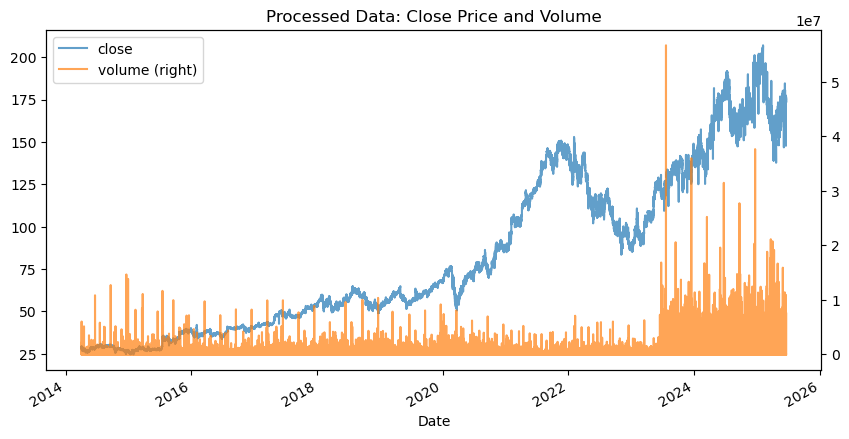

,open,high,low,close,volume,ask,bid
datetime,,,,,,,
2014-04-03 10:42:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:43:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:04:00,28.6500,28.6500,28.6500,28.6500,11220.0,28.658595,28.641405
2014-04-03 11:05:00,28.6500,28.6500,28.6500,28.6500,4620.0,28.658595,28.641405
2014-04-03 11:34:00,28.5005,28.5005,28.5005,28.5005,3460.0,28.509050,28.491950
...,...,...,...,...,...,...,...
2025-06-18 23:55:00,173.9000,173.9445,173.8670,173.8681,3136.0,173.920300,173.815900
2025-06-18 23:56:00,173.8200,173.9500,173.7900,173.9000,183.0,173.952200,173.847800
2025-06-18 23:57:00,173.9500,173.9500,173.8600,173.8601,240.0,173.912300,173.807900


In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = stockanalibs.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=bidasktoclose_spread,
                                vol_fact=1)
df

In [4]:
display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


In [5]:
def plot_trades(df, trades, buy_threshold, performance_stats, trade_color="green"):
    """
    Plots the overall close-price series plus trade intervals and two continuous signals,
    with the signals shown on a secondary y-axis.

    • The base trace (grey) plots the close-price series on the primary y-axis.
    • Trade traces (green by default) indicate the intervals for each trade from the original trade list.
    • A dotted blue line shows the raw normalized "signal" on a secondary y-axis.
    • A dashed red line shows the smooth normalized signal on the secondary y-axis.
    • A horizontal dotted line is drawn at the buy_threshold.
    • Additionally, areas between each buy and sell event determined by the new 
      "trade_action" field (buy=+1, sell=-1) are highlighted (in orange).
    • An update menu is added with two buttons:
         - "Hide Trades": Hides only the trade-specific traces.
         - "Show Trades": Makes all traces visible.

    Parameters:
      df : pd.DataFrame
          DataFrame with a datetime index and at least the columns "close", "signal_scaled", "signal_smooth", and "trade_action".
      trades : list
          A list of tuples, each in the form:
            ((buy_date, sell_date), (buy_price, sell_price), profit_pc).
      buy_threshold : float
          The threshold used for candidate buy detection (shown as a horizontal dotted line on the 
          secondary y-axis).
      performance_stats : dict, optional
          Dictionary containing performance metrics. If provided and if it contains keys
          "Trade Gains ($)" and "Trade Gains (%)" (each a list), they will be added to the
          trade annotations. 
      trade_color : str, optional
          The color to use for the original trade traces.
    """
    fig = go.Figure()
    
    # Trace 0: Base close-price trace.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['close'],
        mode='lines',
        line=dict(color='grey', width=1),
        name='Close Price',
        hoverinfo='x+y',
        hovertemplate="Date: %{x}<br>Close: %{y:.2f}<extra></extra>",
    ))
    
    # Trade traces: one per original trade.
    for i, trade in enumerate(trades):
        # Unpack the trade tuple: ((buy_date, sell_date), (buy_price, sell_price), profit_pc)
        (buy_date, sell_date), (_, _), trade_return = trade
        trade_df = df.loc[buy_date:sell_date]
        fig.add_trace(go.Scatter(
            x=trade_df.index,
            y=trade_df['close'],
            mode='lines+markers',
            line=dict(color=trade_color, width=3),
            marker=dict(size=4, color=trade_color),
            name=f"Trade {i+1}",
            hoveron='points',
            hovertemplate=f"Trade {i+1}: Return: {trade_return:.2f}%<extra></extra>",
            visible=True
        ))
        
    # --------------------------------------------------------------------
    # New Trade Action Highlights: using the 'trade_action' field.
    # Extract rows where trade_action is not zero.
    trade_events = df[df["trade_action"] != 0]["trade_action"]
    pairs = []
    prev_buy = None
    for timestamp, action in trade_events.items():
        if action == 1:   # Buy signal
            prev_buy = timestamp
        elif action == -1 and prev_buy is not None:
            pairs.append((prev_buy, timestamp))
            prev_buy = None
    # For each buy-sell pair, add a vertical shaded region with annotation.
    for j, (buy_ts, sell_ts) in enumerate(pairs):
        if (performance_stats is not None and 
            "Trade Gains ($)" in performance_stats and 
            "Trade Gains (%)" in performance_stats and 
            len(performance_stats["Trade Gains ($)"]) > j and 
            len(performance_stats["Trade Gains (%)"]) > j):
            ann_text = (f"TA Trade {j+1}<br>$: {performance_stats['Trade Gains ($)'][j]}<br>"
                        f"%: {performance_stats['Trade Gains (%)'][j]}")
        else:
            ann_text = f"TA Trade {j+1}"
            
        fig.add_vrect(
            x0=buy_ts, x1=sell_ts,
            fillcolor="orange", opacity=0.25,
            line_width=0,
            annotation_text=ann_text,
            annotation_position="top left",
            annotation_font_color="orange"
        )
    # --------------------------------------------------------------------
    
    # Raw Signal trace: Plot the normalized "signal" on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_scaled'],
        mode='lines',
        line=dict(color='blue', width=2, dash='dot'),
        name='Raw Sign.',
        hovertemplate="Date: %{x}<br>Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Smooth Signal trace: Plot the smooth normalized signal on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_smooth'],
        mode='lines',
        line=dict(color='red', width=2, dash='dash'),
        name='Smooth Sign',
        hovertemplate="Date: %{x}<br>Smooth Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Add a horizontal dotted line for the buy_threshold (on secondary y-axis).
    fig.add_hline(y=buy_threshold, line=dict(color="purple", dash="dot"),
                  annotation_text="Buy Threshold", annotation_position="top left", yref="y2")
    
    # Total traces: 1 Base + n_trades (original trades) + 2 (for the signal traces).
    n_trades = len(trades)
    total_traces = 1 + n_trades + 2
    vis_show = [True] * total_traces  
    vis_hide = [True] + ["legendonly"] * n_trades + [True, True]
    
    fig.update_layout(
        updatemenus=[
            {
                "type": "buttons",
                "direction": "left",
                "buttons": [
                    {
                        "label": "Hide Trades",
                        "method": "update",
                        "args": [{"visible": vis_hide}],
                    },
                    {
                        "label": "Show Trades",
                        "method": "update",
                        "args": [{"visible": vis_show}],
                    },
                ],
                "pad": {"r": 10, "t": 10},
                "showactive": True,
                "x": 0.9,
                "xanchor": "left",
                "y": 1.1,
                "yanchor": "top",
            }
        ],
        hovermode="x unified",
        template="plotly_white",
        title="Close Price, Trade Intervals, and Signals",
        xaxis_title="Datetime",
        yaxis_title="Close Price",
        height=700,
        yaxis2=dict(
            title="Signal (Normalized)",
            overlaying="y",
            side="right",
            showgrid=False,
        )
    )
    
    fig.show()


In [6]:

def aggregate_performance(perf_list, round_digits=3):
    """
    Given a list of daily performance dictionaries, aggregate them as follows:
      - For numeric keys, sum their values and round the result.
      - For list keys (like "Trade Gains ($)" and "Trade Gains (%)"), replace them
        with a message indicating the number of trades.
    Then update:
      - "Strategy Profit Difference ($)" = "Final Net Value ($)" - "Buy & Hold Gain ($)"
      - "Strategy Improvement (%)"    = "Final Net Return (%)" - "Buy & Hold Return (%)"
    Returns the aggregated performance dictionary.
    """
    aggregated = {}
    keys = set()
    for perf in perf_list:
        if perf is not None:
            keys.update(perf.keys())
    for key in keys:
        if key in ["Trade Gains ($)", "Trade Gains (%)"]:
            temp_list = []
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], list):
                    temp_list.extend(perf[key])
            aggregated[key] = f"{len(temp_list)} trades"
        else:
            total = 0
            for perf in perf_list:
                if perf and key in perf and isinstance(perf[key], (int, float)):
                    total += perf[key]
            aggregated[key] = round(total, round_digits)
    if "Final Net Value ($)" in aggregated and "Buy & Hold Gain ($)" in aggregated:
        aggregated["Strategy Profit Difference ($)"] = round(
            aggregated["Final Net Value ($)"] - aggregated["Buy & Hold Gain ($)"], round_digits)
    if "Final Net Return (%)" in aggregated and "Buy & Hold Return (%)" in aggregated:
        aggregated["Strategy Improvement (%)"] = round(
            aggregated["Final Net Return (%)"] - aggregated["Buy & Hold Return (%)"], round_digits)
    return aggregated



In [7]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    reference_gain,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM') → process each day, then summary
      • Day   ('YYYY-MM-DD') → process that day only
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress bar, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open", "high", "low", "close", "volume",
            "bid", "ask", "trade_action",
            "StrategyEarning", "EarningDiff", "signal_smooth"
        ]

    performance_list = []

    # -------------------------------------------------------------------------
    # Helper #1: identify → signal → simulate
    # -------------------------------------------------------------------------
    def run_trading_pipeline(slice_df, day_to_check=None):
        trades_by_day = stockanalibs.identify_trades_daily(
            df=slice_df,
            min_prof_thr=min_prof_thr,
            max_down_prop=max_down_prop,
            gain_tightening_factor=gain_tightening_factor,
            regular_start_shifted=stockanalibs.regular_start_shifted,
            regular_end=stockanalibs.regular_end,
            merging_retracement_thr=merging_retracement_thr,
            merging_time_gap_thr=merging_time_gap_thr,
            day_to_check=day_to_check
        )
        signaled = stockanalibs.add_trade_signal_to_results(
            results_by_day_trad=trades_by_day,
            min_prof_thr=min_prof_thr,
            regular_start=stockanalibs.regular_start,
            reference_gain=reference_gain,
            smooth_win_sig=smooth_win_sig,
            pre_entry_decay=pre_entry_decay,
            buy_threshold=buy_threshold,
            trailing_stop_thresh=trailing_stop_thresh,
            is_centered=stockanalibs.is_centered
        )
        sim_results = stockanalibs.simulate_trading(
            results_by_day_sign=signaled,
            regular_start=stockanalibs.regular_start,
            regular_end=stockanalibs.regular_end,
            ticker=ticker
        )

        if day_to_check:
            target = pd.to_datetime(day_to_check).date()
            for ts, triple in sim_results.items():
                if ts.date() == target:
                    return triple
            return None
        return sim_results

    # -------------------------------------------------------------------------
    # Helper #2: merge & interpolate with tqdm
    # -------------------------------------------------------------------------
    def merge_and_interpolate(sim_dict):
        # 1) Gather each day's DataFrame slice
        daily_dfs = [triple[0][keep_cols] for triple in sim_dict.values()]
        merged = pd.concat(daily_dfs).sort_index()
        merged.index = pd.to_datetime(merged.index)
        merged = merged.dropna()

        # 2) Interpolate day by day with a progress bar
        unique_days = sorted(set(merged.index.normalize()))
        chunks = []
        for day in tqdm(unique_days, desc="Interpolating days"):
            block = merged.loc[merged.index.normalize() == day]
            full_idx = pd.date_range(
                start=block.index.min(),
                end=block.index.max(),
                freq="min"
            )
            interp = block.reindex(full_idx).interpolate(
                method="linear", limit_direction="both"
            )
            chunks.append(interp)

        return pd.concat(chunks)

    # -------------------------------------------------------------------------
    # Helper #3: process one calendar day
    # -------------------------------------------------------------------------
    def process_single_day(day_str):
        print(f"\n=== Processing trading day {day_str} ===")
        day_dt = pd.to_datetime(day_str)
        day_df = df.loc[df.index.normalize() == day_dt].copy()
        if day_df.empty:
            print(" no data; skipping.")
            return

        try:
            day_df = stockanalibs.smooth_prepost_trading_data(
                df=day_df,
                regular_start=stockanalibs.regular_start,
                regular_end=stockanalibs.regular_end,
                red_pretr_win=stockanalibs.red_pretr_win
            )
        except ValueError as ve:
            if "window 0" in str(ve):
                print(" warning: smoothing window=0; skipping smoothing.")
            else:
                raise

        result = run_trading_pipeline(day_df, day_to_check=day_str)
        if result is None:
            print(" no trades found; skipping.")
            return

        df_day, trades_day, perf_day = result

        plot_trades(
            df=df_day,
            trades=trades_day,
            buy_threshold=buy_threshold,
            performance_stats=perf_day
        )
        plt.show(block=False)
        plt.close()

        performance_list.append(perf_day)

        order = [
            "Final Net Value ($)", "Buy & Hold Gain ($)",
            "Strategy Profit Difference ($)", "Final Net Return (%)",
            "Buy & Hold Return (%)", "Strategy Improvement (%)",
            "Trade Gains ($)", "Trade Gains (%)"
        ]
        summary = OrderedDict()
        for key in order:
            if key in perf_day:
                val = perf_day[key]
                summary[key] = round(val, 3) if isinstance(val, (int, float)) else val

        print(" Daily Performance:")
        for k, v in summary.items():
            print(f"   {k}: {v}")

    # -------------------------------------------------------------------------
    # Main dispatch
    # -------------------------------------------------------------------------
    if date_to_check:
        # Month mode: 'YYYY-MM'
        if len(date_to_check) == 7:
            print(f"\nMonth mode: processing {date_to_check}")
            days = df.loc[df.index.strftime("%Y-%m") == date_to_check]\
                     .index.normalize().unique()
            for d in sorted(days.astype(str)):
                process_single_day(d)

            monthly_summary = aggregate_performance(performance_list)
            print(f"\nFinal Summary for month {date_to_check}:")
            pprint(monthly_summary)
            return None

        # Single-day mode: 'YYYY-MM-DD'
        return process_single_day(date_to_check)

    # -------------------------------------------------------------------------
    # Full-run mode (date_to_check=None)
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode: started at {datetime.now():%H:%M:%S}")

    # Step A: smooth & DST-adjust whole DataFrame
    print(" Step A: smoothing & DST adjust …")
    df_smooth = stockanalibs.smooth_prepost_trading_data(
        df=df,
        regular_start=stockanalibs.regular_start,
        regular_end=stockanalibs.regular_end,
        red_pretr_win=stockanalibs.red_pretr_win
    )

    # Step B: identify → signal → simulate on full dataset
    print(" Step B: running trading pipeline on full dataset …")
    full_sim_results = run_trading_pipeline(df_smooth, day_to_check=None)

    # Step C: merge & interpolate with progress bar
    print(" Step C: merging & interpolating all days …")
    merged = merge_and_interpolate(full_sim_results)

    # Step D: save CSV
    out_path = f"dfs training/{ticker}_final.csv"
    merged.to_csv(out_path)
    print(f" Step D: saved merged output to {out_path}")
    print(f"All done at {datetime.now():%H:%M:%S}")

    return merged


In [8]:
min_prof_thr, max_down_prop, gain_tightening_factor, smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh, \
merging_retracement_thr, merging_time_gap_thr = stockanalibs.signal_parameters(ticker)

In [9]:
def compute_reference_gain(df):
    """
    Computes the *relative* reference gain (%) as the average daily % range:
       daily_pct_range = (high.max - low.min) / low.min
    Returns a float like 0.025 if on average days swing 2.5%.
    (used afterwards to adjust the smoothed continuous signal , while normalizing it)
    """
    # Ensure your index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # For each calendar day compute (high.max - low.min) / low.min
    daily_pct = (
        df.groupby(df.index.date)
          .apply(lambda d: (d["high"].max() - d["low"].min()) / d["low"].min())
    )
    # If you want it in percent points, multiply by 100 here.
    return daily_pct.mean()

reference_gain = compute_reference_gain(df)

In [10]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=ticker,
                        min_prof_thr=min_prof_thr, 
                        max_down_prop=max_down_prop, 
                        gain_tightening_factor=gain_tightening_factor,
                        smooth_win_sig=smooth_win_sig, 
                        pre_entry_decay=pre_entry_decay, 
                        buy_threshold=buy_threshold, 
                        trailing_stop_thresh=trailing_stop_thresh,
                        merging_retracement_thr=merging_retracement_thr, 
                        merging_time_gap_thr=merging_time_gap_thr,
                        reference_gain=reference_gain,
                        date_to_check=date_to_check
                        )

df_fin


Full-run mode: started at 17:55:09
 Step A: smoothing & DST adjust …
 Step B: running trading pipeline on full dataset …
 Step C: merging & interpolating all days …


Interpolating days:   0%|          | 0/2818 [00:00<?, ?it/s]

 Step D: saved merged output to dfs training/GOOGL_final.csv
All done at 18:07:56


,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth
2014-04-03 13:33:00,28.5959,28.5959,28.5932,28.5932,5540.0,28.5846,28.6018,0,0.000,0.000,0.750262
2014-04-03 13:34:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.760984
2014-04-03 13:35:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.770777
2014-04-03 13:36:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.779774
2014-04-03 13:37:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.788084
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.3750,173.6771,173.2150,173.5650,621199.0,173.5129,173.6171,0,-0.661,2.049,0.000000
2025-06-18 20:57:00,173.5650,173.5900,173.2400,173.3800,624198.0,173.3280,173.4320,0,-0.661,2.234,0.000000
2025-06-18 20:58:00,173.3900,173.4100,173.2000,173.3100,454542.0,173.2580,173.3620,0,-0.661,2.304,0.000000
2025-06-18 20:59:00,173.3150,173.4000,173.2300,173.2800,1094746.0,173.2280,173.3320,0,-0.661,2.334,0.000000
